# BERT Fine-Tuning Tutorial with PyTorch

By Chris McCormick and Nick Ryan

*Revised on 12/13/19 to use the new [transformers](https://github.com/huggingface/transformers) interface.*




## 1.1. Using Colab GPU for Training


In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/new-stg/home/banghua/anaconda3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There are 1 GPU(s) available.
We will use the GPU: NVIDIA RTX A6000


## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available.

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [2]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df_train = pd.read_csv("~/med264/Dataset1/day1_30mortality_train.csv", index_col=0)
num_train_pos = df_train[df_train['Label'] == 1].shape[0]
num_train_neg = df_train[df_train['Label'] == 0].shape[0]
num_balanced = min(num_train_pos, num_train_neg)
df_train_pos = df_train[df_train['Label'] == 1].sample(n=num_balanced, random_state=42)
df_train_neg = df_train[df_train['Label'] == 0].sample(n=num_balanced, random_state=42)
df_train = pd.concat([df_train_pos, df_train_neg])

df_val = pd.read_csv("~/med264/Dataset1/day1_30mortality_val.csv", index_col=0)
num_val_pos = df_val[df_val['Label'] == 1].shape[0]
num_val_neg = df_val[df_val['Label'] == 0].shape[0]
num_balanced = min(num_val_pos, num_val_neg)
df_val_pos = df_val[df_val['Label'] == 1].sample(n=num_balanced, random_state=42)
df_val_neg = df_val[df_val['Label'] == 0].sample(n=num_balanced, random_state=42)
df_val = pd.concat([df_val_pos, df_val_neg])

df_test = pd.read_csv("~/med264/Dataset1/day1_30mortality_test.csv", index_col=0)
num_test_pos = df_test[df_test['Label'] == 1].shape[0]
num_test_neg = df_test[df_test['Label'] == 0].shape[0]
num_balanced = min(num_test_pos, num_test_neg)
df_test_pos = df_test[df_test['Label'] == 1].sample(n=num_balanced, random_state=42)
df_test_neg = df_test[df_test['Label'] == 0].sample(n=num_balanced, random_state=42)
df_test = pd.concat([df_test_pos, df_test_neg])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))
print('Number of validation sentences: {:,}\n'.format(df_val.shape[0]))
print('Number of testing sentences: {:,}\n'.format(df_test.shape[0]))

Number of training sentences: 26,108

Number of validation sentences: 3,100

Number of testing sentences: 3,246



In [3]:
# Get the lists of sentences and their labels.
sentences_train = df_train.TEXT.values
labels_train = df_train.Label.values
sentences_val = df_val.TEXT.values
labels_val = df_val.Label.values
sentences_test = df_test.TEXT.values
labels_test = df_test.Label.values

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [4]:
from transformers import BertTokenizer
import os
model_path = os.path.expanduser('~/med264/clinicalBERTs/pretraining_checkpoint/')
# Load the BERT tokenizer.
print('Loading BertTokenizer tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_path)

Loading BertTokenizer tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [5]:
# Print the original sentence.
print(' Original: ', sentences_train[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences_train[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences_train[0])))

 Original:  throughout the aorta. there is no hilar, mediastinal, or axillary lymphadenopathy. ct of the abdomen with iv contrast: ng tube is noted within the stomach. the adrenal glands, pancreas, gallbladder, and liver are within normal limits. there is a small splenic cyst near the splenic hilum. the kidneys are shrunken and atrophic bilaterally. multiple cysts are noted with the largest in the right kidney measuring up to 6 cm. there is no retroperitoneal or mesenteric lymphadenopathy. there is no free air or free fluid. (over) 1:44 pm cta chest w&w/o c&recons, non-coronary; ct abdomen w/contrast clip # ct pelvis w/contrast reason: r/o pe final report (cont) ct of the pelvis with iv contrast: the rectum and sigmoid colon are abnormal with wall thickening, adjacent fat stranding, and relative of the wall. the remainder of the bowel wall appears within normal limits. there is no evidence of obstruction. the abdominal and pelvic arterial vasculature is heavily calcified. however, ther

## 3.2. Sentences to IDs

In [6]:
from tqdm import tqdm
import os
import pickle

# Correct the path by expanding the tilde to the user's home directory
file_path_train = os.path.expanduser('~/med264/Dataset3/input_ids_train.pickle')
file_path_valid = os.path.expanduser('~/med264/Dataset3/input_ids_valid.pickle')
file_path_test = os.path.expanduser('~/med264/Dataset3/input_ids_test.pickle')


input_ids_train, input_ids_valid, input_ids_test = [], [], []

if os.path.exists(file_path_train):
    with open(file_path_train, 'rb') as f:
        input_ids_train = pickle.load(f)
    print('Loaded input_ids_train.')
else:
    for sent in tqdm(sentences_train):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_train.append(encoded_sent)
    with open(file_path_train, 'wb') as f:
        pickle.dump(input_ids_train, f)
    print('Saved input_ids_train.')


if os.path.exists(file_path_valid):
    with open(file_path_valid, 'rb') as f:
        input_ids_valid = pickle.load(f)
    print('Loaded input_ids_valid.')
else:
    for sent in tqdm(sentences_val):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_valid.append(encoded_sent)
    with open(file_path_valid, 'wb') as f:
        pickle.dump(input_ids_valid, f)
    print('Saved input_ids_valid.')

if os.path.exists(file_path_test):
    with open(file_path_test, 'rb') as f:
        input_ids_test = pickle.load(f)
    print('Loaded input_ids_test.')
else:
    for sent in tqdm(sentences_test):
        encoded_sent = tokenizer.encode(sent, add_special_tokens = True)
        input_ids_test.append(encoded_sent)
    with open(file_path_test, 'wb') as f:
            pickle.dump(input_ids_test, f)
    print('Saved input_ids_test.')
    

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences_train[0])
print('Token IDs:', input_ids_train[0])

100%|███████████████████████████████████████████████████████████████████████████████████████| 26108/26108 [01:40<00:00, 259.59it/s]


Saved input_ids_train.


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3100/3100 [00:11<00:00, 269.47it/s]


Saved input_ids_valid.


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3246/3246 [00:12<00:00, 267.98it/s]


Saved input_ids_test.
Original:  throughout the aorta. there is no hilar, mediastinal, or axillary lymphadenopathy. ct of the abdomen with iv contrast: ng tube is noted within the stomach. the adrenal glands, pancreas, gallbladder, and liver are within normal limits. there is a small splenic cyst near the splenic hilum. the kidneys are shrunken and atrophic bilaterally. multiple cysts are noted with the largest in the right kidney measuring up to 6 cm. there is no retroperitoneal or mesenteric lymphadenopathy. there is no free air or free fluid. (over) 1:44 pm cta chest w&w/o c&recons, non-coronary; ct abdomen w/contrast clip # ct pelvis w/contrast reason: r/o pe final report (cont) ct of the pelvis with iv contrast: the rectum and sigmoid colon are abnormal with wall thickening, adjacent fat stranding, and relative of the wall. the remainder of the bowel wall appears within normal limits. there is no evidence of obstruction. the abdominal and pelvic arterial vasculature is heavily cal

In [7]:
print('Max train sentence length: ', max([len(sen) for sen in input_ids_train]))
print('Max valid sentence length: ', max([len(sen) for sen in input_ids_valid]))
print('Max test sentence length: ', max([len(sen) for sen in input_ids_test]))

Max train sentence length:  881
Max valid sentence length:  1066
Max test sentence length:  818


Given that, let's choose MAX_LEN = 64 and apply the padding.

In [8]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 512
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids_train = pad_sequences(input_ids_train, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
input_ids_valid = pad_sequences(input_ids_valid, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
input_ids_test = pad_sequences(input_ids_test, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

print('\nDone.')

2023-11-30 11:41:26.271183: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 11:41:30.945440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 11:41:30.945494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 11:41:31.760995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 11:41:32.598965: I tensorflow/core/platform/cpu_feature_guar


Padding/truncating all sentences to 512 values...

Padding token: "[PAD]", ID: 0

Done.


## 3.4. Attention Masks

In [9]:
# Create attention masks
attention_masks_train, attention_masks_valid, attention_masks_test = [], [], []

# For each sentence...
for sent in input_ids_train:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_train.append(att_mask)

for sent in input_ids_valid:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_valid.append(att_mask)

for sent in input_ids_test:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks_test.append(att_mask)

## 3.5. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [10]:
train_inputs, validation_inputs, test_inpputs, train_labels, validation_labels, test_labels =\
input_ids_train, input_ids_valid, input_ids_test, labels_train, labels_val, labels_test

train_masks, validation_masks, test_masks = attention_masks_train, attention_masks_valid, attention_masks_test

## 3.6. Converting to PyTorch Data Types

Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [11]:
# Convert all inputs and labels into torch tensors, the required datatype
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [12]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# 4. Train Our Classification Model

In [13]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained(model_path, num_labels = 2, output_attentions = False, output_hidden_states = False).cuda()

In [14]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

In [17]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/new-stg/home/banghua/anaconda3/envs/LLM/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. At each pass we need to:

Training loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass.
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

Evalution loop:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

So please read carefully through the comments to get an understanding of what's happening. If you're unfamiliar with pytorch a quick look at some of their [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will help show you that training loops really involve only a few simple steps; the rest is usually just decoration and logging.  

Define a helper function for calculating accuracy.

In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times.


In [21]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready to kick off the training!

In [22]:
import random

seed_val = 42

model_path = os.path.expanduser('~/med264/models_balanced_clinicalBERT/')
if not os.path.exists(model_path):
    os.makedirs(model_path)

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    model.save_pretrained(model_path + str(epoch_i))

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    408.    Elapsed: 0:01:05.
  Batch    80  of    408.    Elapsed: 0:02:03.
  Batch   120  of    408.    Elapsed: 0:03:00.
  Batch   160  of    408.    Elapsed: 0:03:59.
  Batch   200  of    408.    Elapsed: 0:04:57.
  Batch   240  of    408.    Elapsed: 0:05:55.
  Batch   280  of    408.    Elapsed: 0:06:53.
  Batch   320  of    408.    Elapsed: 0:07:51.
  Batch   360  of    408.    Elapsed: 0:08:50.
  Batch   400  of    408.    Elapsed: 0:09:48.

  Average training loss: 0.60
  Training epcoh took: 0:10:04

Running Validation...
  Accuracy: 0.70
  Validation took: 0:00:24

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    408.    Elapsed: 0:00:58.
  Batch    80  of    408.    Elapsed: 0:01:56.
  Batch   120  of    408.    Elapsed: 0:02:55.
  Batch   160  of    408.    Elapsed: 0:03:53.
  Batch   200  of    408.    Elapsed: 0:04:51.
  Batch   240  of    408.    Elapsed: 0:05:49.
  Batch   280  of    408.    El

In [23]:
# Save loss_values
with open(model_path + 'loss_values.pickle', 'wb') as f:
    pickle.dump(loss_values, f)

Let's take a look at our training loss over all batches:

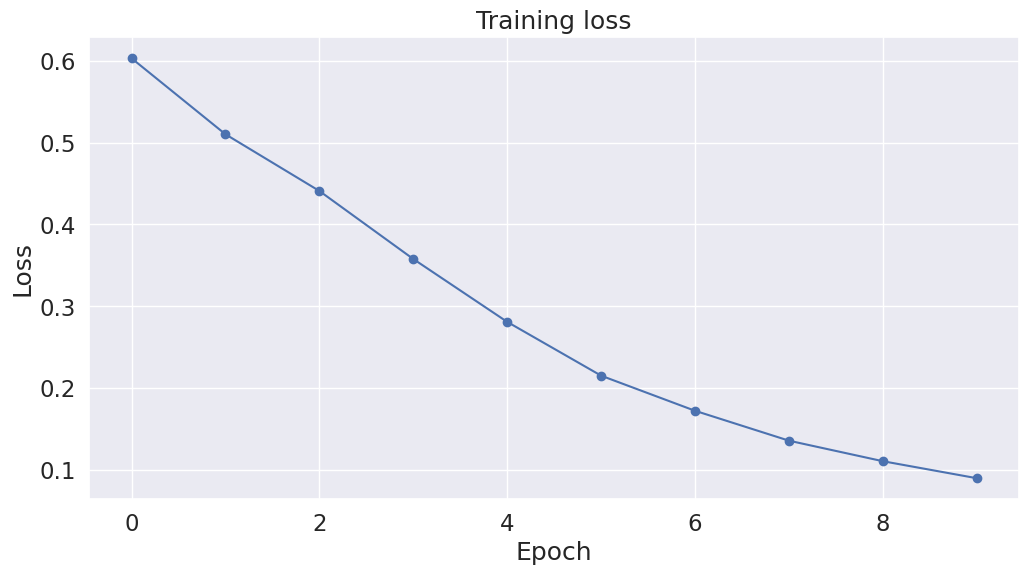

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Save the plot to file.
plt.savefig("clinicalBERT_Fine_Tuning_balanced_loss.png", dpi = 300)

plt.show()

In [26]:
# Save ipynb session
import dill
dill.dump_session('BERT_Fine_Tuning_Sentence_Classification_v2.db')